# EDA를 진행하며 겪은 가설 검증 과정과 현실


부제: 화창한 주말, 사람들은 외출을 했을까? 
- 전력사용량을 통해 외출 여부를 판별하고, 외출에 영향을 주는 날씨요인을 분석해본다.

저희 팀의 주제인 '전력사용량 예측' 데이터에는 특정 건물들의 전력사용량과 날씨에 관련된 요소들이 시계열로 저장되어 있습니다.

그래서 1) 특정 건물들을 전력소비 패턴을 기준으로 분류하여 가정집을 특정하고, 2) 해당 가정집이 주말에 외출을 했는지 여부를 파악하고자 했습니다.

이 주제를 진행하기 위해 세웠던 가설과 한계점은 다음과 같습니다.

가설
1. raw data 중에는 가정집의 전력소모량 데이터가 포함되어 있다.
2. 가정집의 전력소모가 적은 날은 외출을 했다고 볼 수 있다.
3. 사람들이 외출을 결정하는데는 날씨요소(기온, 풍속, 습도, 강수량, 일조량)가 영향을 끼쳤을 것이다.

한계점
1. raw data에서 가정집임을 정확하게 판별할 수 없음(추정되는 패턴으로 확인)
2. 거주인이 외출했음을 정확하게 판별할 수 없음(전력소모량이 적음=외출 이 성립 가능한가?)
3. 정확한 외출 데이터가 없어, 날씨와 관계없이 외출해야 하는 경우 등은 고려되지 못함.

그러나 EDA를 진행하며 전력소모량으로 외출 여부를 가정하는 것 자체가 성립하기 어려움을 깨달고 저희 조의 주제는 `가설을 세우고 검증하는 과정에 대한 진행과 결과`로 선회하게 되었습니다.

순서
1. 데이터 전처리
   1. 데이터 정보 확인
   2. 결측치 확인
   3. 컬럼명 변경
   4. datetime 컬럼 세분화
2. raw data에서 가정집 찾아내기
    * 각 건물별 요일-시간별 히트맵
    * 스케일링 및 군집화
3. 가정집 데이터의 특징들 확인
   1. 가정집 건물들의 유형별 전력소모량 시각화
      * 요일별
      * 시간별
   2. 외출의 기준잡기
      * 가정집의 주말 시간대별 평균 전력사용량
      * 외부데이터, 평균 주말 가정 전력소모량
      * 
4. 주말 외출과 날씨요인의 관계
   1. 각 날씨요인별 상관관계 확인
      1. 기온
      2. 풍속
      3. 습도
      4. 강수량
      5. 일조량
   2. 추가변수 생성(체감온도, 불쾌지수)
      1. 체감온도
      2. 불쾌지수

5. 결론


In [3]:
# # 처음 한 번만 실행하고 주석처리. 
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,681 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and d

## 0. 들어가며

In [1]:
import numpy as np #Analysis 
import pandas as pd #Analysis 

from tqdm import tqdm #Visulization
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans #

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('seaborn')

# 한글 폰트 설정
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name, size=15)
plt.rcParams['axes.unicode_minus'] = False
fm._rebuild()

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/sandropark/Aiffel/main/energy/train.csv', encoding='cp949') # 인코딩 오류
print("train.csv. Shape: ",train.shape)

train.csv. Shape:  (122400, 10)


## 1. 데이터 전처리

### 1.1 데이터 정보확인

In [ ]:
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


### 1.2 결측치 확인

In [ ]:
train.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

train 데이터에서 결측치는 존재하지 않습니다.

### 1.3 컬럼명 변경

In [3]:
cols = ['num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전냉설', '태양광'] # 비전기냉방설비운영, 태양광보유
train.columns = cols

원활한 코딩 진행을 위해 컬럼명을 변경해주었습니다.

### 1.4 datetime 컬럼 세분화

In [4]:
#요일을 지정하는 함수
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [5]:
# 시간 특성을 datetime 객체로 변경
train['date_time'] = pd.to_datetime(train['date_time'])
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].dt.weekday # 0-월요일

train.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전냉설,태양광,day,month,hour,weekday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,6,0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,6,1,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,6,2,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,6,3,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,6,4,0


그리고 date_time 컬럼은 yyyy-mm-dd + hh 형태로 지정되어 있어, 이를 각 요소들로 세분화해주었습니다.

## 2. raw data에서 가정집 찾아내기

데이터셋에는 60개의 건물 데이터가 있습니다.  
저희의 가설은 각 건물의 용처에 따라 전력소비패턴이 다를것이며, 패턴에 따라 가정집 추정이 가능하다는 것 입니다.

이를 위해 각 건물별로 전력소비패턴을 확인하고 시각화를 진행했습니다.

### 2.1 각 건물별 요일-시간별 히트맵

100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


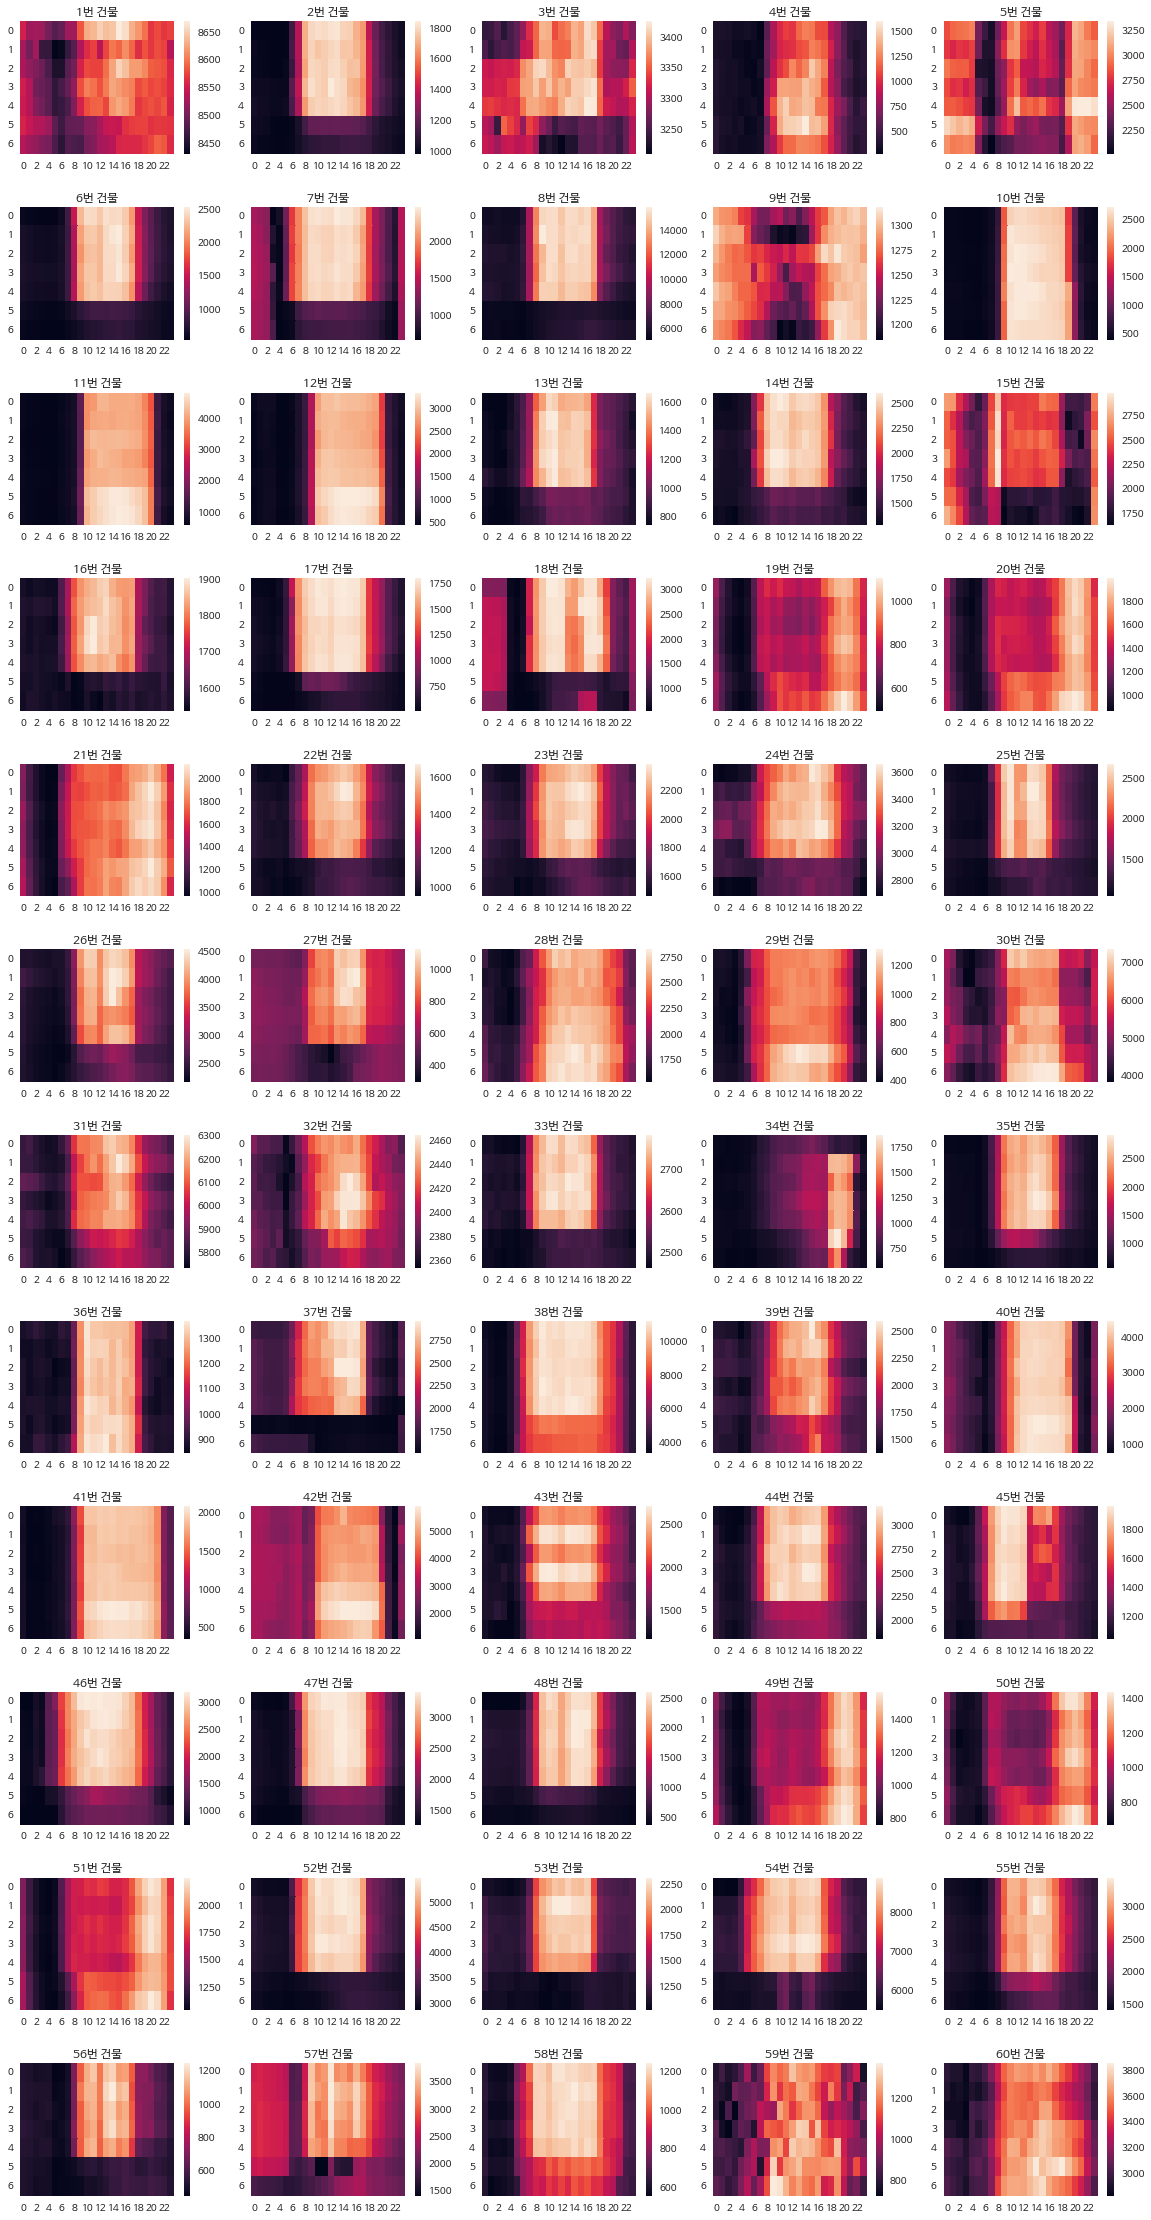

In [ ]:
# X : 시간, Y : 요일 , 전력사용량 중앙값
fig = plt.figure(figsize=(20,40))
for num in tqdm(train['num'].unique()):
    df = train[train['num'] == num]
    df = df.groupby(['weekday','hour'])['전력사용량'].median().reset_index().pivot('weekday','hour','전력사용량')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'{num}번 건물')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

plt.subplots_adjust(hspace=0.4)

각 건물별 datetime에 따른 전력사용량 패턴을 확인하기 위해 히트맵으로 그려봤습니다.  
x 축은 `hour`, y 축은 `weekday`, value는 `전력사용량`입니다.  

여기선 크게 세 가지를 확인 가능합니다.
* 평일 낮에만 전력사용량이 높은 건물
* 평일, 주말 구분없이 낮에만 전력사용량이 높은 건물
* 그 외 낮-밤 구분없이 전력사용량이 높은 건물

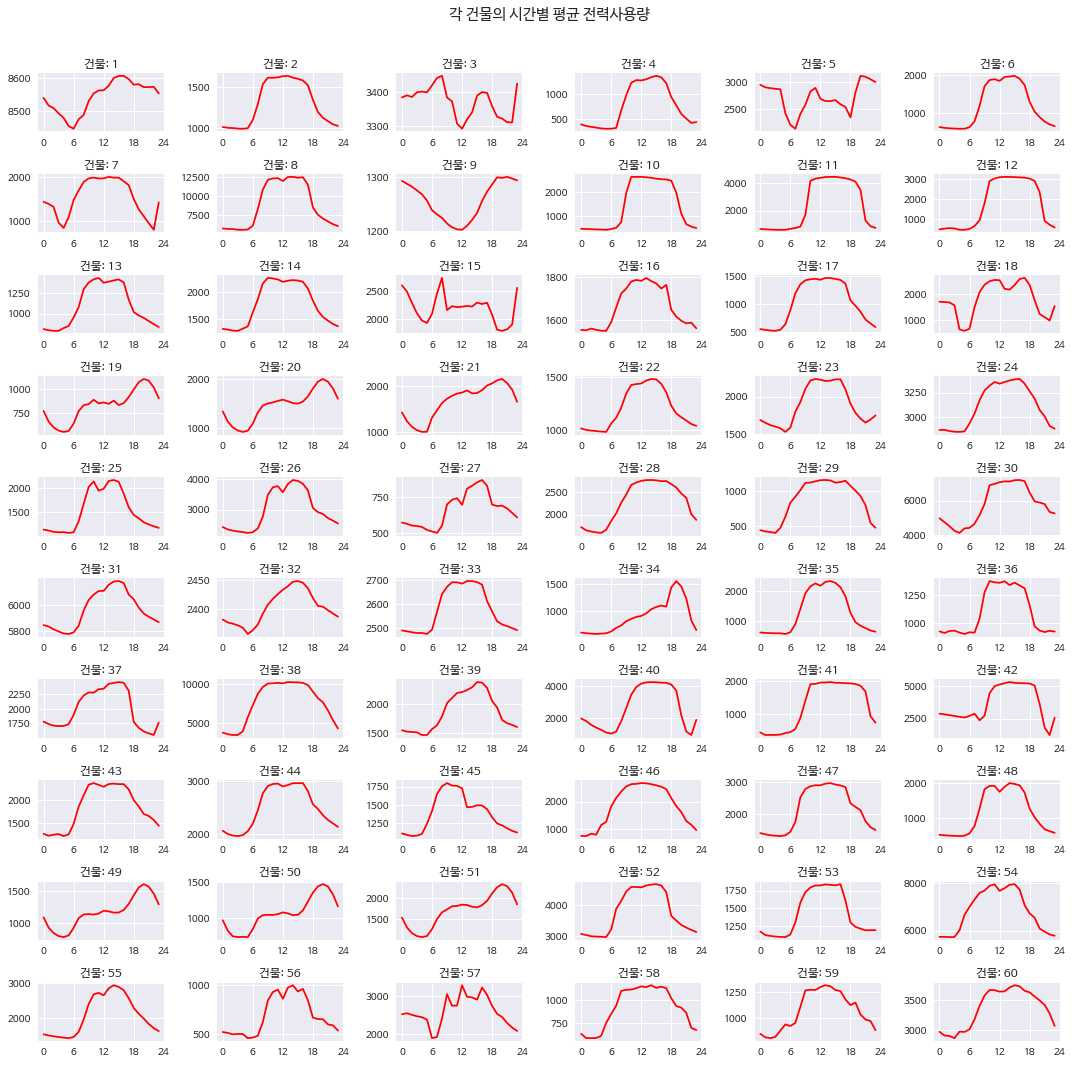

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간별 평균 전력사용량", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train[train.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df.groupby('hour')['전력사용량'].mean(),color='R')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
plt.tight_layout()
plt.show()

각 건물의 시간별 평균 전력사용량 시각화입니다.  
x 축은 `hour`, y축은 `전력사용량`입니다.  

꺽은선 그래프로 보니 위에서 확인했던 건물별 패턴 유형이 더욱 눈에 잘 띄었습니다.

그리고 저희의 가설이었던 `건물은 용처에 따라 다른 사용패턴을 가진다`를 확인할 

### 2.2 스케일링 및 군집화

위에서 확인한 건물별 전력사용패턴을 가지고 비슷한 건물끼리 그룹화를 해봤습니다.

In [6]:
# 건물별 요일,시간별 전력사용량 중앙값 데이터프레임 생성

by_weekday = train.groupby(['num','weekday'])['전력사용량'].median().reset_index().pivot('num','weekday','전력사용량').reset_index()
by_hour = train.groupby(['num','hour'])['전력사용량'].median().reset_index().pivot('num','hour','전력사용량').reset_index().drop('num',axis=1)
df = pd.concat([by_weekday, by_hour], axis=1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns
df.head()

,num,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,8565.588000,8552.628,8567.208,8574.336,8562.996000,8535.780,8521.524,8546.472,8526.384,...,8600.256,8607.384,8606.088,8598.960,8576.280,8586.000,8573.688,8577.576,8577.576,8558.784
1,2,1261.008000,1304.100,1303.776,1318.356,1300.050000,1074.546,1056.726,1008.288,1001.160,...,1707.480,1697.112,1693.224,1622.268,1367.280,1204.956,1124.604,1078.920,1039.068,1021.248
2,3,3369.363177,3351.834,3381.480,3382.668,3374.500282,3260.736,3250.800,3274.884,3272.400,...,3388.338,3385.152,3406.212,3394.872,3334.176,3295.512,3290.760,3283.524,3283.740,3327.588
3,4,538.488000,547.992,554.256,582.984,612.360000,602.640,608.256,372.816,355.104,...,1294.704,1288.224,1236.384,1121.472,917.568,748.224,566.352,479.520,405.216,422.496
4,5,2761.992000,2732.184,2730.240,2650.752,2880.792000,2747.736,2585.952,2999.808,2920.320,...,2630.880,2667.600,2584.224,2552.256,2344.896,2788.992,3132.000,3111.696,3091.824,3013.200


먼저 건물별로 요일과 시간별로 전력사용량의 평균을 구해서 새로운 데이터프레임을 생성했습니다.

In [7]:
# 스케일링
for i in range(len(df)):
    # 요일
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

같은 패턴을 가지고 있는 건물이어도 사용량자체는 다르기 때문에 직관적으로 비교하기 위해서 요일별, 시간별로 정규화작업을 했습니다.

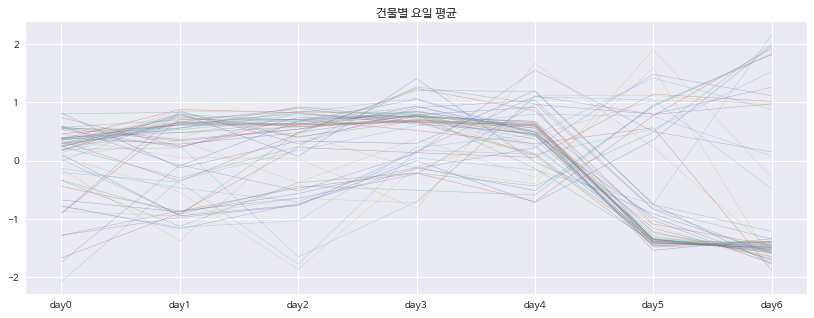

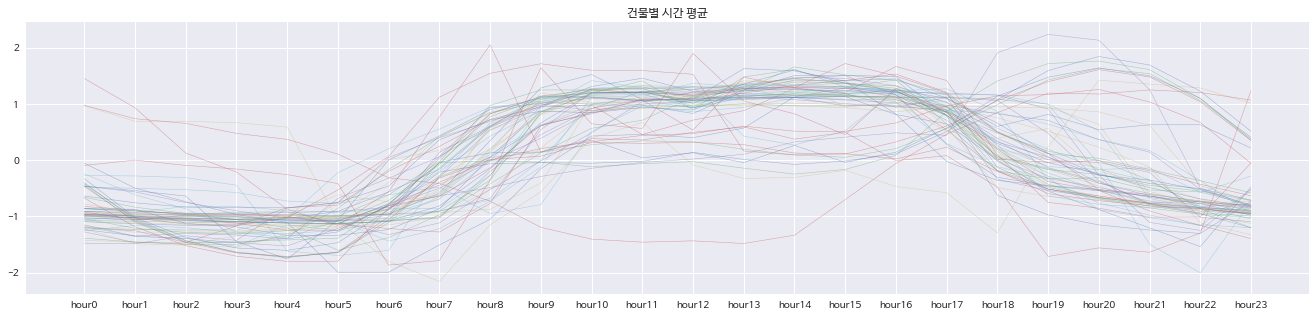

In [8]:
# 시각화

# 요일
fig = plt.figure(figsize=(14,5))
for i in range(len(df)):
    plt.plot(df.iloc[i,1:8],alpha=0.5,linewidth=0.5)
plt.title('건물별 요일 평균')

# 시간
fig = plt.figure(figsize=(23,5))
for i in range(len(df)):
    plt.plot(df.iloc[i,8:],alpha=0.5,linewidth=0.5)
plt.title('건물별 시간 평균')

plt.show()

정규화를 거친 후 모든 건물의 요일별 그래프와 시간별 그래프를 그려보니 뚜렸한 패턴을 찾을 수 있었습니다.

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1,1:3,2:2,3:0})
df_clust.head()

,num,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23,km_cluster
0,1,0.590985,-0.087195,0.675757,1.048756,0.455349,-0.968828,-1.714825,-0.054554,-0.495728,...,1.283201,1.254738,1.098192,0.600092,0.813564,0.543166,0.628555,0.628555,0.215843,0
1,2,0.259920,0.635967,0.633139,0.760373,0.600624,-1.367257,-1.522765,-1.031987,-1.053854,...,1.081104,1.069177,0.851507,0.069285,-0.428673,-0.675167,-0.815311,-0.937564,-0.992230,1
2,3,0.530408,0.226509,0.740475,0.761071,0.619469,-1.352837,-1.525096,-1.199306,-1.253455,...,1.204446,1.663537,1.416334,0.093211,-0.749632,-0.853222,-1.010961,-1.006252,-0.050402,1
3,4,-1.280487,-0.973568,-0.771281,0.156449,1.105105,0.791211,0.972572,-0.904856,-0.950505,...,1.454404,1.320798,1.024638,0.499121,0.062674,-0.406060,-0.629851,-0.821353,-0.776817,2
4,5,0.378345,0.055196,0.034121,-0.827608,1.666255,0.223795,-1.530104,0.966190,0.691945,...,-0.179973,-0.467631,-0.577925,-1.293345,0.238846,1.422270,1.352218,1.283657,1.012394,0


K-Mean 모델을 사용해서 군집화 했습니다.

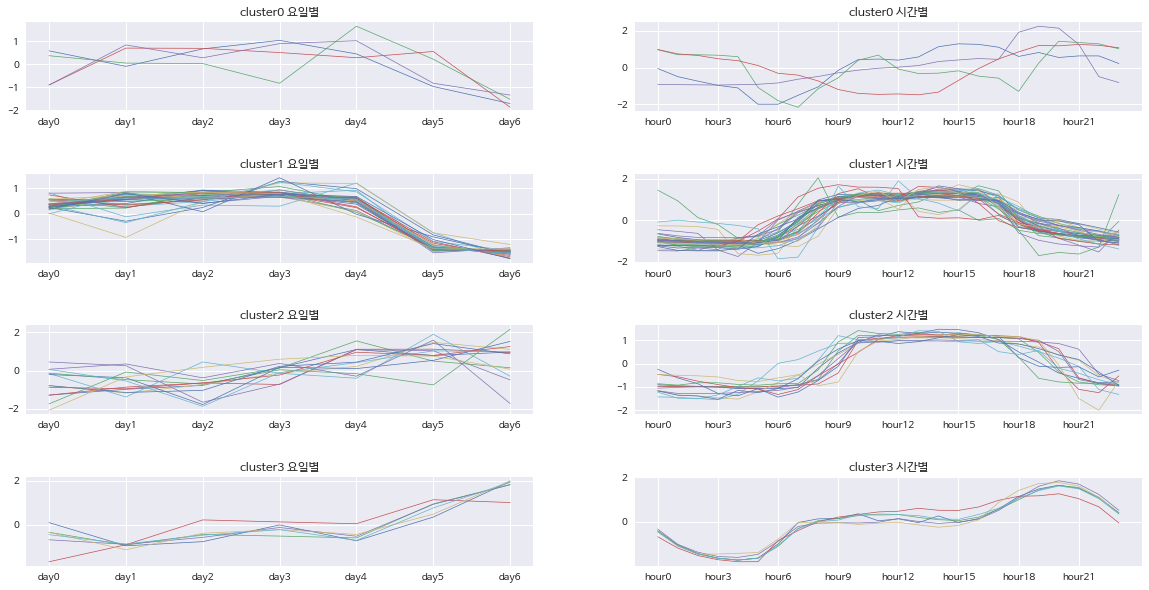

In [10]:
# 군집 시각화
num_clusts = len(df_clust['km_cluster'].unique())

fig = plt.figure(figsize=(20,10))
# 클러스트 0부터
for clust in range(num_clusts):
    temp = df_clust[df_clust['km_cluster'] == clust]
    
    # 요일별
    plt.subplot(num_clusts,2,2*clust+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7)
        plt.title(f'cluster{clust} 요일별')
        # plt.xlabel('')
        # plt.xticks([])

    # 시간별
    plt.subplot(num_clusts,2,2*clust+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-1], linewidth=0.7)
        plt.title(f"cluster{clust} 시간별")
        plt.xticks(np.arange(0,24,3))

    plt.subplots_adjust(hspace=0.7)

군집화 후 군집별로 요일별, 시간별로 시각화한 데이터입니다. 군집화를 하고 보니 확실히 군집별로 뚜렷한 패턴을 확인할 수 있습니다. 

- 0번 군집 : 데이터가 얼마 없지만 평일에는 전력사용량이 높았다가 주말이 되면 낮아지는 모습을 확인할 수 있습니다. 

- 1번 군집 : 가장 뚜렷한 패턴을 나타내는 군집입니다. 평일에는 높았다가 휴일에는 낮아지는 패턴을 보입니다. 시간으로 봐도 오전 6시 이후로 높아지고 오후 6시를 기점으로 낮아지는 패턴을 보입니다. 근무시간에 전력사용량이 높아지는 사무실로 추측할 수 있습니다.

- 2번 군집 : 주말이 될 수록 전력사용량이 높아지는 패턴을 보입니다. 시간으로 보면 군집 1과 비슷한 패턴을 보입니다.

- 3번 군집 : 저희가 가정집이라고 가정한 군집입니다. 일하러 출근하는 평일에는 낮은 전력사용량을 보이다가 주말이 되면 늘어나는 것을 확인할 수 있습니다. 시간은 오전 7시부터 오후 4시까지 일정하고 퇴근시간이 가까운 오후 5시부터는 전력사용량이 늘어나는 것을 확인할 수 있습니다.

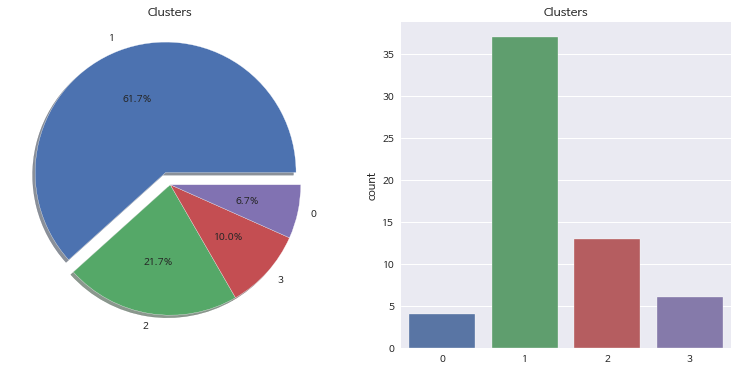

In [ ]:
f,ax = plt.subplots(1,2,figsize=(13,6))
df_clust['km_cluster'].value_counts().plot.pie(explode=[0.1,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Clusters')
ax[0].set_ylabel('')

sns.countplot('km_cluster', data=df_clust, ax=ax[1])
ax[1].set_title('Clusters')
ax[1].set_xlabel('')
plt.show()

군집의 크기를 시각화해서 보면 60% 이상의 건물이 1번 군집에 해당하는 것을 확인할 수 있습니다.

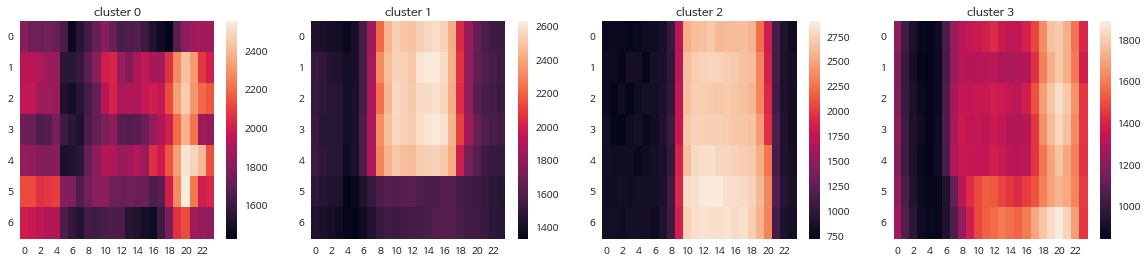

In [13]:
# 군집별 요일, 시간별 전력사용 패턴 시각화
eda_df = train.copy()
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num',how = 'left')

fig = plt.figure(figsize=(20,4))

for c in range(4):
    temp = eda_df[eda_df['km_cluster'] == c]
    temp = temp.groupby(['weekday','hour'])['전력사용량'].median().reset_index().pivot('weekday','hour','전력사용량')
    plt.subplot(1,4,c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

각 군집마다 요일과 시간별로 시각화하면 군집별로 뚜렷하게 구분되는 패턴을 확인할 수 있습니다.

## 3. 가정집 데이터의 특징들 확인

In [14]:
cluster_0 = eda_df[eda_df["km_cluster"] == 0].reset_index(drop=True)
cluster_1 = eda_df[eda_df["km_cluster"] == 1].reset_index(drop=True)
cluster_2 = eda_df[eda_df["km_cluster"] == 2].reset_index(drop=True)
cluster_3 = eda_df[eda_df["km_cluster"] == 3].reset_index(drop=True)

cluster_3['num'].unique()

array([19, 20, 21, 49, 50, 51])

### 3.1 가정집 건물들의 유형별 전력소모량 시각화

#### 3.1.1 요일별

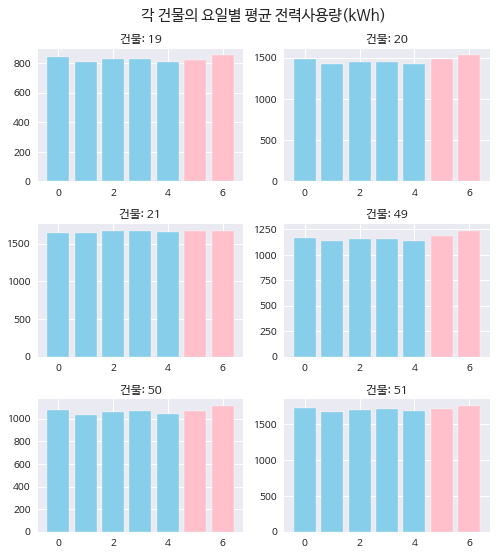

In [ ]:
fig = plt.figure(figsize = (7 ,8))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

nums = cluster_3['num'].unique()

weekday = ['월','화','수','목','금','토','일']
colors = ['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for idx,num in enumerate(nums):
    df = cluster_3[cluster_3.num==num]
    df_counts = df.groupby('weekday')['전력사용량'].mean()
    ax = fig.add_subplot(3,2,idx+1)
    ax.bar(df['weekday'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

요일 별로 큰 편차없이 꾸준하게 전력을 소비하며 평일과 주말 역시 큰 차이를 보이진 않습니다.

#### 3.1.2 시간별

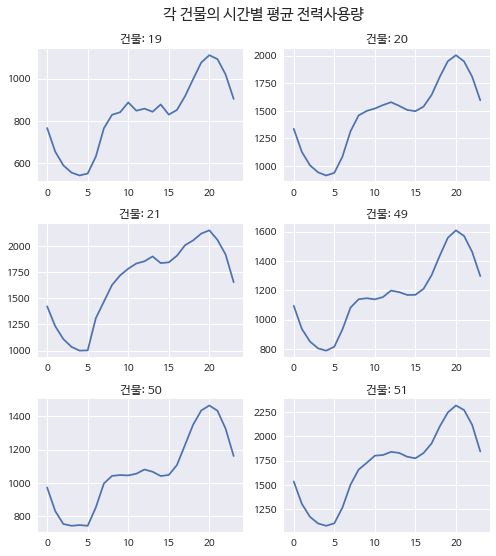

In [ ]:
fig = plt.figure(figsize = (7 ,8))
plt.title("각 건물의 시간별 평균 전력사용량", fontsize=15, y=1.05)
plt.axis('off')

for idx,num in enumerate(nums):
    df = cluster_3[cluster_3.num==num]
    ax = fig.add_subplot(3,2,idx+1)
    ax.plot(df['hour'].unique(), df.groupby('hour')['전력사용량'].mean())
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

가정집 유형의 각 건물의 시간별 전력사용량입니다.

## 4. 전력소비량과 변수들의 상관관계

클러스터 진행을 통해 4개의 유형으로 각 건물들을 분류했고 저희는 가정집으로 추정되는 3번 클러스터의 데이터로 분석을 진행했습니다.

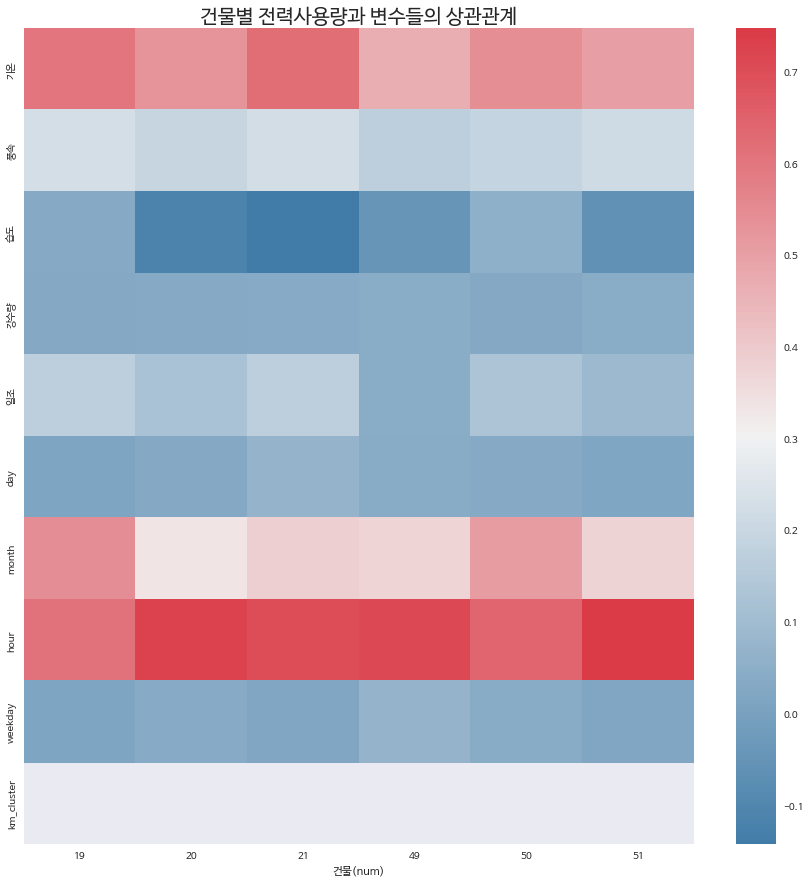

In [ ]:
num_clust3 = cluster_3['num'].unique()

corr = []
for num in num_clust3:
    df = cluster_3[cluster_3.num==num]
    num_corr = df.corr()['전력사용량']
    num_corr = num_corr.drop(['num','비전냉설','태양광','전력사용량'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(num_clust3)

# 시각화
f, ax = plt.subplots(figsize=(15,15))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=20)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('건물(num)')
plt.show()

In [21]:
cluster_3[['전력사용량','기온','풍속','습도','강수량','일조','비전냉설','태양광','hour','weekday']]

,전력사용량,기온,풍속,습도,강수량,일조,비전냉설,태양광,hour,weekday
0,640.062,18.3,2.5,94.0,0.0,0.0,0.0,0.0,0,0
1,540.270,18.8,2.3,89.0,0.0,0.0,0.0,0.0,1,0
2,494.262,19.0,3.2,86.0,0.0,0.0,0.0,0.0,2,0
3,471.906,19.0,4.1,85.0,0.0,0.0,0.0,0.0,3,0
4,472.878,18.9,3.9,87.0,0.0,0.0,0.0,0.0,4,0
...,...,...,...,...,...,...,...,...,...,...
12235,2909.358,29.4,3.4,66.0,0.0,0.2,0.0,1.0,19,0
12236,2934.954,28.7,1.9,69.0,0.0,0.0,0.0,1.0,20,0
12237,2780.406,28.3,1.1,71.0,0.0,0.0,0.0,1.0,21,0
12238,2529.468,28.3,2.4,72.0,0.0,0.0,0.0,1.0,22,0


['전력사용량' '태양광' 'hour' '기온' '습도' '일조' '풍속' 'weekday' '강수량']


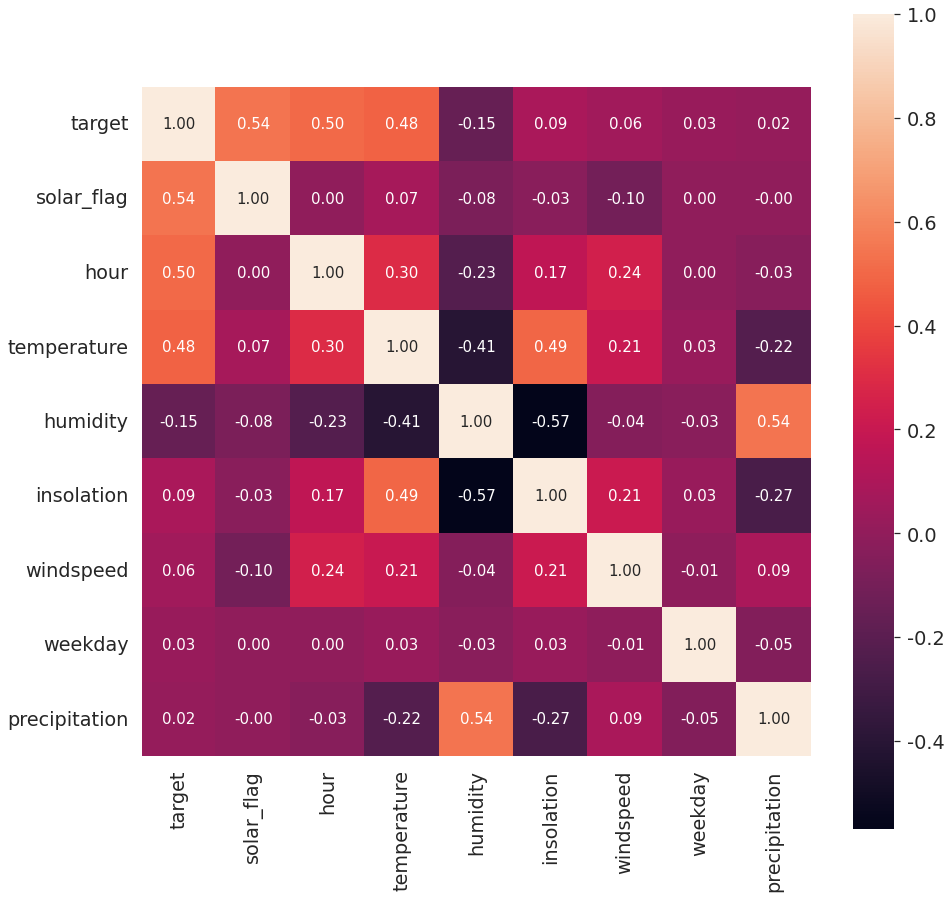

In [24]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(cluster_3[['전력사용량','기온','풍속','습도','강수량','일조','비전냉설','태양광','hour','weekday']].corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='전력사용량').index # 전력사용량(kWh)과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(cluster_3[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
col = ['target','solar_flag','hour','temperature','humidity','insolation','windspeed','weekday','precipitation']
plt.figure(figsize=(15,15))
sns.set(font_scale=1.75)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 15} ,xticklabels=col, yticklabels=col)
plt.show()

### 4.1 다중회귀분석을 통한 날씨요인별 상관관계 확인

#### 4.1.1 기온

In [26]:
print(cluster_3['기온'].min())
print(cluster_3['기온'].max())

14.8
35.2


In [27]:
cluster_3.loc[cluster_3['기온']>=34, '기온_c']='34~39'
cluster_3.loc[(cluster_3['기온']>=29)&(cluster_3['기온']<34), '기온_c']='29~33'
cluster_3.loc[(cluster_3['기온']>=24)&(cluster_3['기온']<29), '기온_c']='24~28'
cluster_3.loc[(cluster_3['기온']>=19)&(cluster_3['기온']<24), '기온_c']='19~23'
cluster_3.loc[cluster_3['기온']<19, '기온_c']='14~18'

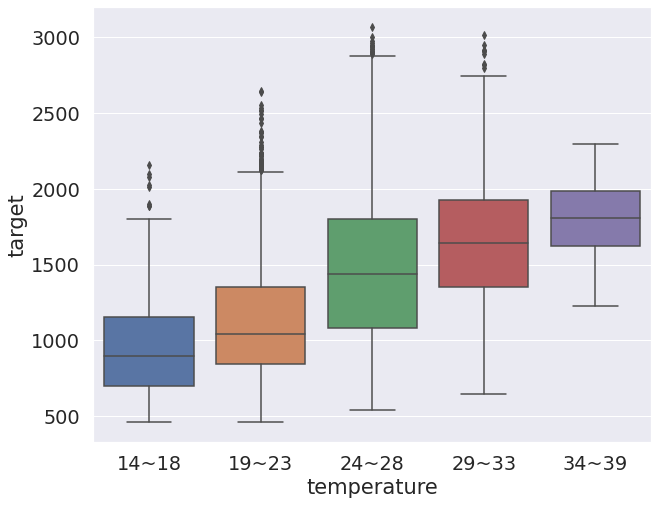

In [30]:
# 기온 분포 확인
data = pd.concat([cluster_3['전력사용량'], cluster_3['기온_c']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='기온_c', y="전력사용량", data=data)
plt.xlabel('temperature')
plt.ylabel('target')
plt.show()

#### 4.1.2 풍속

In [31]:
print(cluster_3['풍속'].min())
print(cluster_3['풍속'].max())

0.0
12.8


In [32]:
cluster_3['풍속_c']=pd.cut(cluster_3.풍속, bins=[0, 3, 6, 9, 12, 15], labels=['0~2', '3~5', '6~8', '9~11', '12~14'])

In [33]:
cluster_3.loc[cluster_3['풍속']>=12, '풍속_b']='12~14'
cluster_3.loc[(cluster_3['풍속']>=9)&(cluster_3['풍속']<12), '풍속_b']='9~11'
cluster_3.loc[(cluster_3['풍속']>=6)&(cluster_3['풍속']<9), '풍속_b']='6~8'
cluster_3.loc[(cluster_3['풍속']>=3)&(cluster_3['풍속']<6), '풍속_b']='3~5'
cluster_3.loc[cluster_3['풍속']<3, '풍속_b']='0~2'

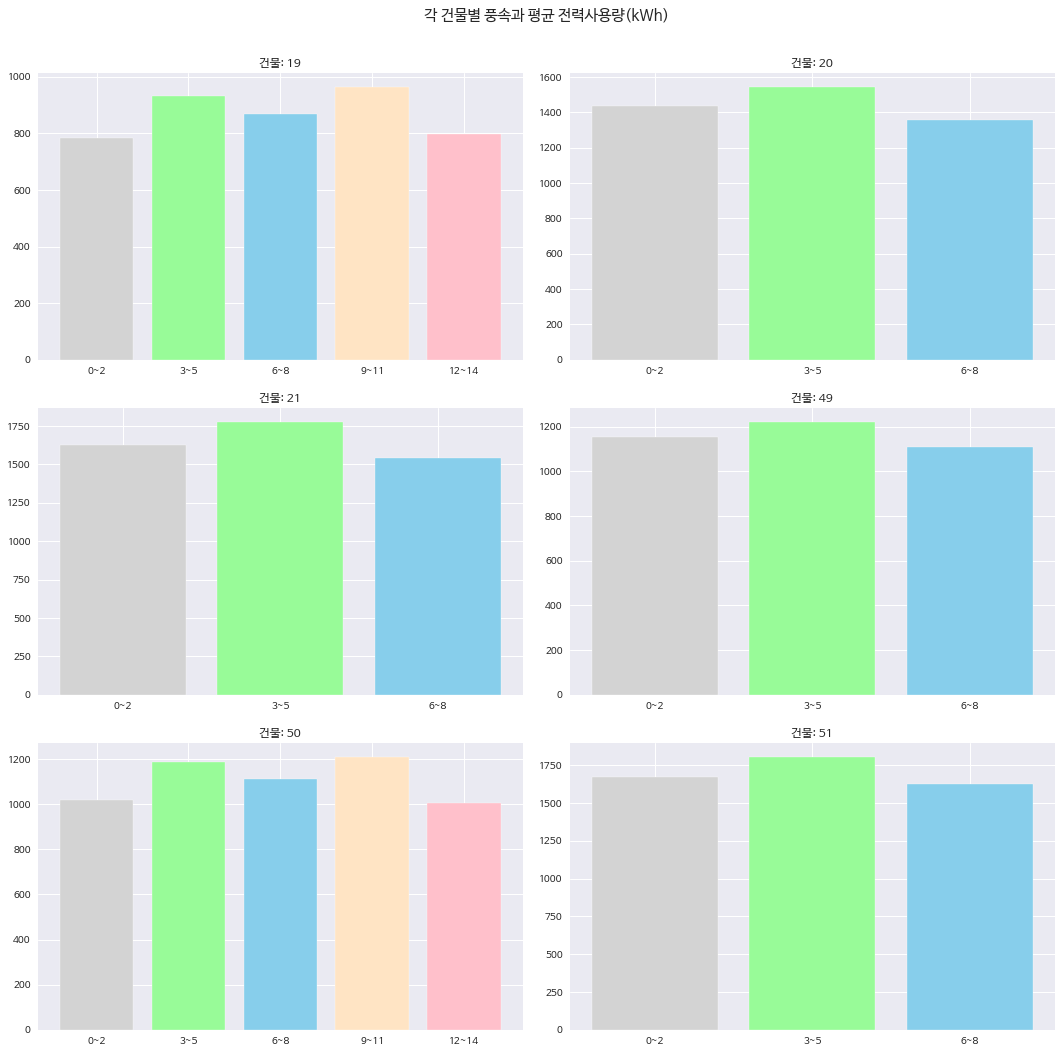

In [ ]:
# 풍속
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물별 풍속과 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

nums = cluster_3['num'].unique()

colors = ['lightgrey', 'palegreen', 'skyblue', 'bisque', 'pink']

for idx,num in enumerate(nums):
    df = cluster_3[cluster_3.num==num]
    df_counts = df.groupby('풍속_b')['전력사용량'].mean()
    ax = fig.add_subplot(3,2,idx+1)
    ax.bar(df['풍속_b'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

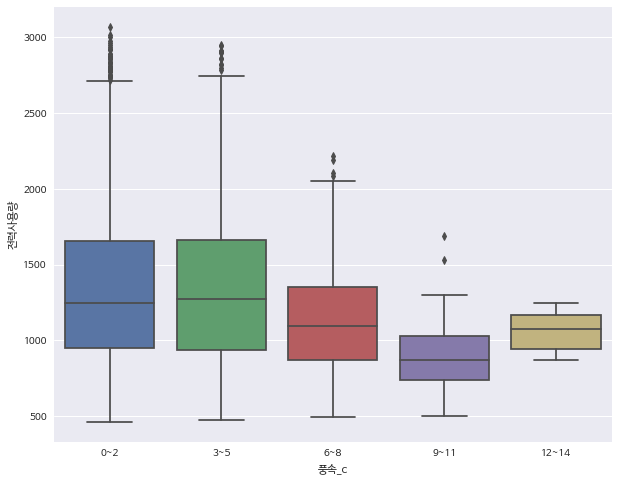

In [ ]:
# 풍속 분포 확인
data = pd.concat([cluster_3['전력사용량'], cluster_3['풍속_c']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='풍속_c', y="전력사용량", data=data)

#### 4.1.3 습도

In [34]:
print(cluster_3['습도'].min())
print(cluster_3['습도'].max())

19.0
100.0


In [35]:
cluster_3['습도_c']=pd.cut(cluster_3.습도, bins=[0, 20, 40, 60, 80, 100], labels=['0~19', '20~39', '40~59', '60~79', '80~100'])

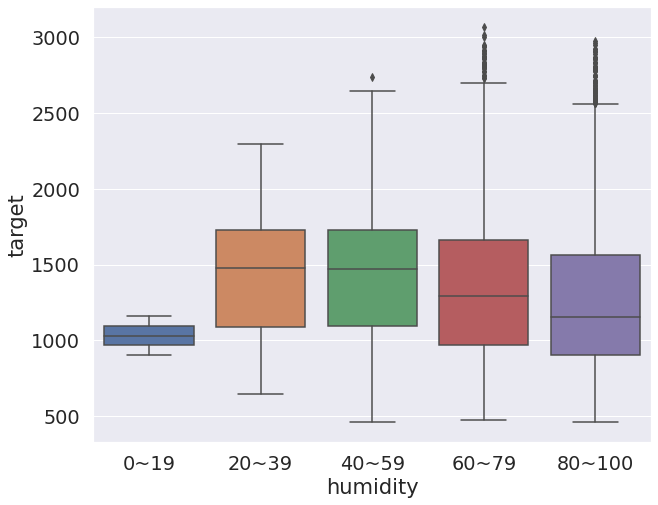

In [39]:
# 습도 분포 확인
data = pd.concat([cluster_3['전력사용량'], cluster_3['습도_c']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='습도_c', y='전력사용량', data=data)
plt.xlabel('humidity')
plt.ylabel('target')
plt.show()

#### 4.1.4 강수량

In [42]:
print(cluster_3['강수량'].min())
print(cluster_3['강수량'].max())

0.0
70.4


In [43]:
cluster_3['강수량_c']=pd.cut(cluster_3.강수량, bins=[0, 15, 30, 45, 60, 75], labels=['0~14', '15~29', '30~44', '45~59', '60~75'])

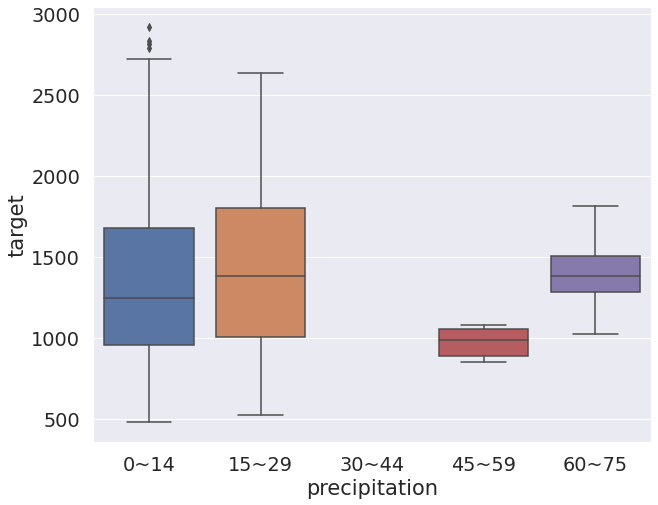

In [45]:
# 강수량 분포 확인
data = pd.concat([cluster_3['전력사용량'], cluster_3['강수량_c']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='강수량_c', y='전력사용량', data=data)
plt.xlabel('precipitation')
plt.ylabel('target')
plt.show()

#### 4.1.5 일조량

In [ ]:
print(cluster_3['일조'].min())
print(cluster_3['일조'].max())

0.0
1.0


### 4.2 추가변수 생성(체감온도, 불쾌지수)

#### 4.2.1 불쾌지수 추가 및 분석

불쾌지수 = $1.8T - 0.55(1-RH)(1.8T-26) + 32$

T = 기온(°C), RH = 상대습도(%)

![](https://mblogthumb-phinf.pstatic.net/20150622_159/hi_nso_1434959593661NrzMw_PNG/%BA%D2%C4%E8%C1%F6%BC%F6.PNG?type=w2)

* x>=80 : 매우높음
* 75<= x <80 : 높음
* 68<= x <75 : 보통
* x <68 : 낮음

In [47]:
cluster_3['불쾌지수'] = 1.8*cluster_3['기온'] - 0.55*(1-(cluster_3['습도']/100))*(1.8*cluster_3['기온']-26) + 32
cluster_3.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전냉설,태양광,...,month,hour,weekday,km_cluster,기온_c,풍속_c,풍속_b,습도_c,강수량_c,불쾌지수
0,19,2020-06-01 00:00:00,640.062,18.3,2.5,94.0,0.0,0.0,0.0,0.0,...,6,0,0,3,14~18,0~2,0~2,80~100,NaN,64.71098
1,19,2020-06-01 01:00:00,540.270,18.8,2.3,89.0,0.0,0.0,0.0,0.0,...,6,1,0,3,14~18,0~2,0~2,80~100,NaN,65.36568
2,19,2020-06-01 02:00:00,494.262,19.0,3.2,86.0,0.0,0.0,0.0,0.0,...,6,2,0,3,19~23,3~5,3~5,80~100,NaN,65.56860
3,19,2020-06-01 03:00:00,471.906,19.0,4.1,85.0,0.0,0.0,0.0,0.0,...,6,3,0,3,19~23,3~5,3~5,80~100,NaN,65.52350
4,19,2020-06-01 04:00:00,472.878,18.9,3.9,87.0,0.0,0.0,0.0,0.0,...,6,4,0,3,14~18,3~5,3~5,80~100,NaN,65.44657


In [48]:
print(cluster_3['불쾌지수'].min())
print(cluster_3['불쾌지수'].max())

58.56608
84.75413


In [56]:
cluster_3['불쾌지수_c']=pd.cut(cluster_3.불쾌지수, bins=[50, 68, 75, 80, 90], labels=['low','medium','high','very-high'])

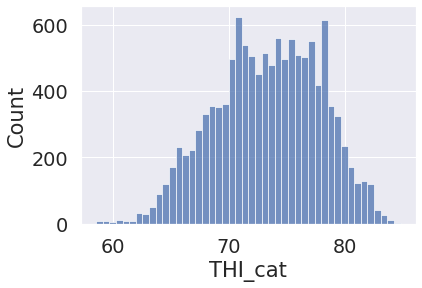

In [57]:
sns.histplot(cluster_3['불쾌지수'])
plt.xlabel('THI_cat')
plt.show()

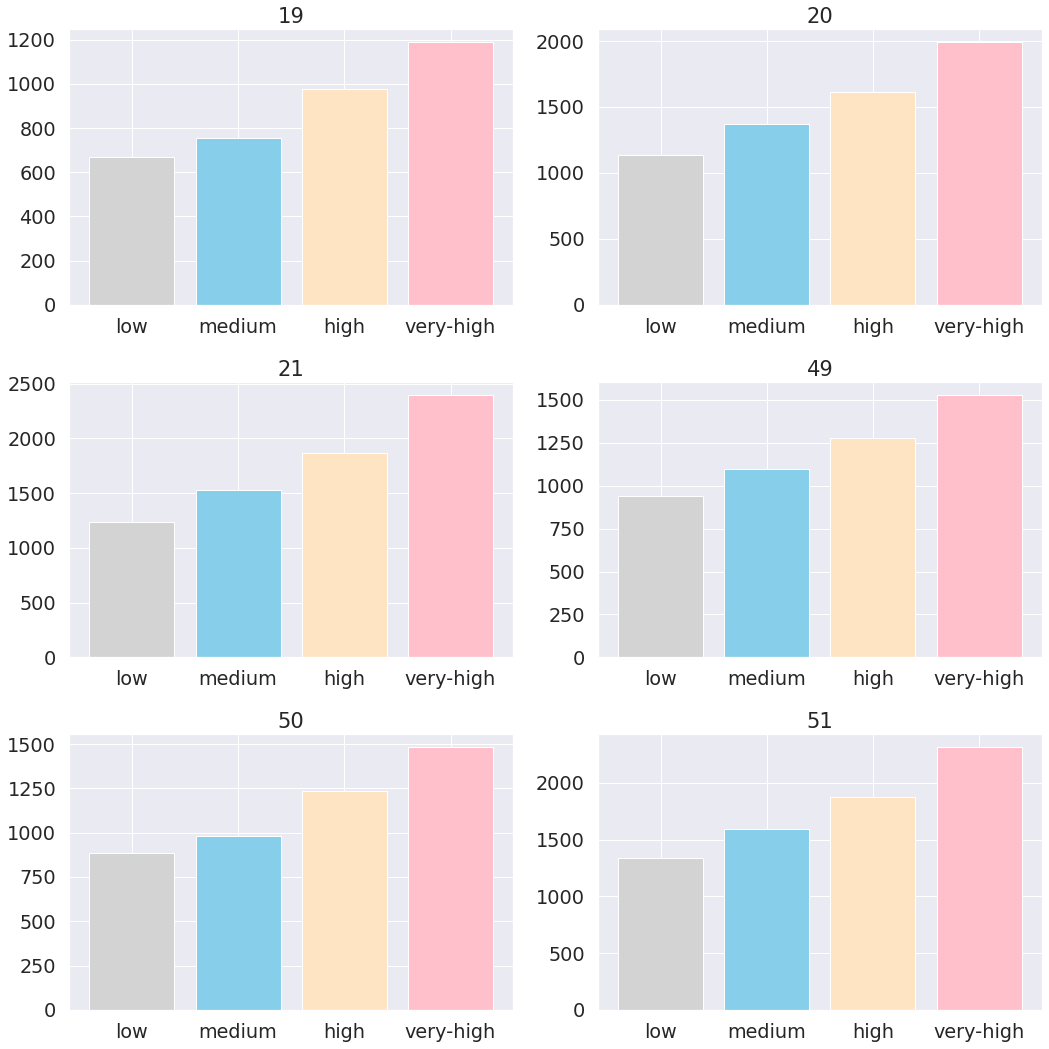

In [58]:
#불쾌지수
fig = plt.figure(figsize = (15 ,15))

nums = cluster_3['num'].unique()

colors = ['lightgrey', 'skyblue', 'bisque', 'pink']

for idx,num in enumerate(nums):
    df = cluster_3[cluster_3.num==num]
    df_counts = df.groupby('불쾌지수_c')['전력사용량'].mean()
    ax = fig.add_subplot(3,2,idx+1)
    ax.bar(df['불쾌지수_c'].unique(), df_counts, color=colors)
    ax.set_title(f'{num}')
plt.tight_layout()
plt.show()

#### 4.2.2 체감온도 분석

체감온도 = $13.12 + 0.6125T - 13.947V^(0.16) + 0.486TV^(0.16)$

T = 기온(°C), V = 풍속(m/s)

![](https://cdn.greenpostkorea.co.kr/news/photo/201712/82655_76168_2532.png)


t >=31: 매우위험
28<= t <31 : 위험
25<= t <28 : 경고
21<= t <25 : 주의
t <21 : 관심



In [64]:
cluster_3['체감온도'] = 13.12+0.6215*cluster_3['기온']-13.947*cluster_3['풍속']**0.16+0.486*cluster_3['기온']*cluster_3['풍속']**0.16
cluster_3.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전냉설,태양광,...,weekday,km_cluster,기온_c,풍속_c,풍속_b,습도_c,강수량_c,불쾌지수,불쾌지수_c,체감온도
0,19,2020-06-01 00:00:00,640.062,18.3,2.5,94.0,0.0,0.0,0.0,0.0,...,0,3,14~18,0~2,0~2,80~100,NaN,64.71098,low,18.642359
1,19,2020-06-01 01:00:00,540.270,18.8,2.3,89.0,0.0,0.0,0.0,0.0,...,0,3,14~18,0~2,0~2,80~100,NaN,65.36568,low,19.308290
2,19,2020-06-01 02:00:00,494.262,19.0,3.2,86.0,0.0,0.0,0.0,0.0,...,0,3,19~23,3~5,3~5,80~100,NaN,65.56860,low,19.251467
3,19,2020-06-01 03:00:00,471.906,19.0,4.1,85.0,0.0,0.0,0.0,0.0,...,0,3,19~23,3~5,3~5,80~100,NaN,65.52350,low,19.021828
4,19,2020-06-01 04:00:00,472.878,18.9,3.9,87.0,0.0,0.0,0.0,0.0,...,0,3,14~18,3~5,3~5,80~100,NaN,65.44657,low,18.946329


In [65]:
print(cluster_3['체감온도'].min())
print(cluster_3['체감온도'].max())

14.890426885459151
38.858383728527656


In [66]:
cluster_3.loc[cluster_3['체감온도']>=31, '체감온도_b']='5'
cluster_3.loc[(cluster_3['체감온도']>=28)&(cluster_3['체감온도']<31), '체감온도_b']='4'
cluster_3.loc[(cluster_3['체감온도']>=25)&(cluster_3['체감온도']<28), '체감온도_b']='3'
cluster_3.loc[(cluster_3['체감온도']>=21)&(cluster_3['체감온도']<25), '체감온도_b']='2'
cluster_3.loc[cluster_3['체감온도']<21, '체감온도_b']='1'

In [67]:
cluster_3['체감온도_b'].unique()

array(['1', '2', '3', '4', '5'], dtype=object)

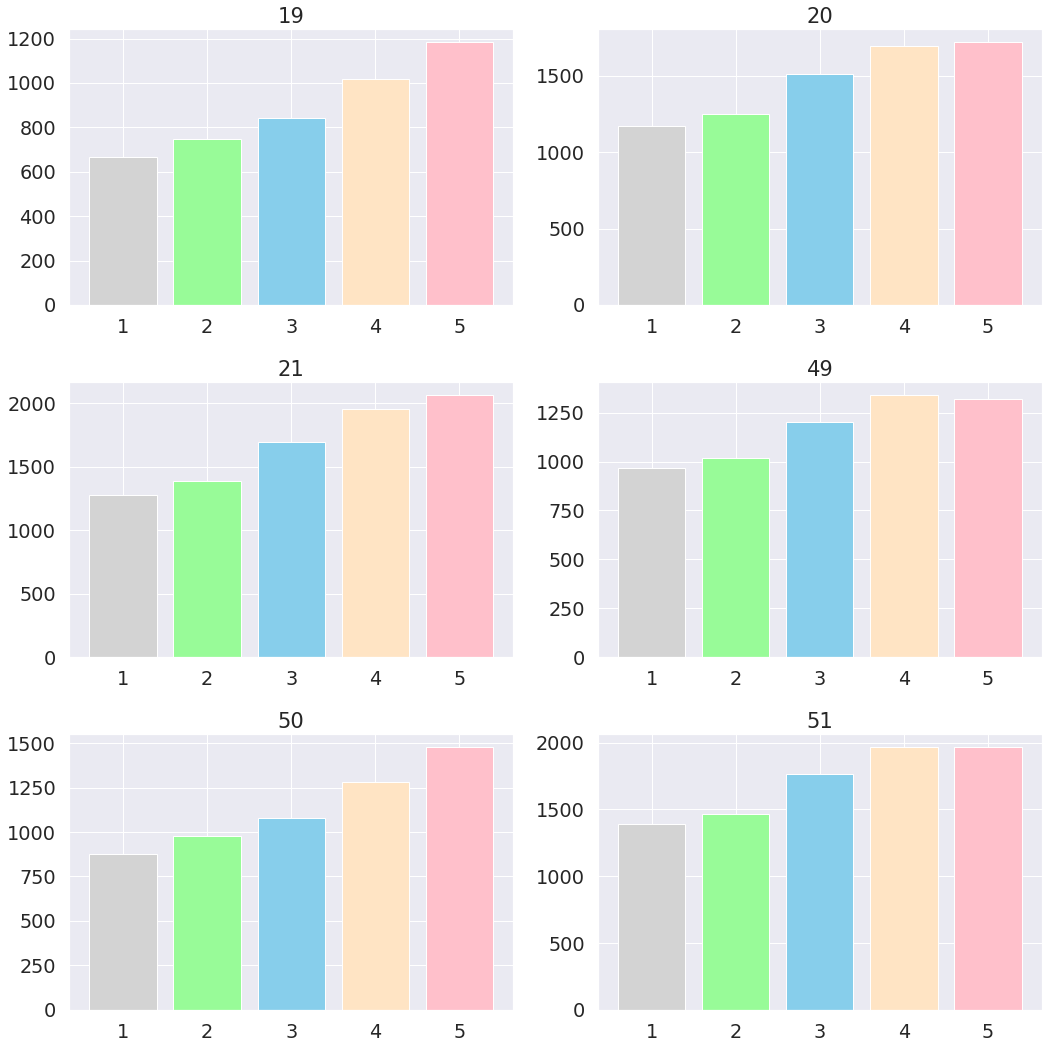

In [70]:
# 체감온도
fig = plt.figure(figsize = (15 ,15))

nums = cluster_3['num'].unique()

colors = ['lightgrey', 'palegreen', 'skyblue', 'bisque', 'pink']

for idx,num in enumerate(nums):
    df = cluster_3[cluster_3.num==num]
    df_counts = df.groupby('체감온도_b')['전력사용량'].mean()
    ax = fig.add_subplot(3,2,idx+1)
    ax.bar(df['체감온도_b'].unique(), df_counts, color=colors)
    ax.set_title(f'{num}')
plt.tight_layout()
plt.show()

In [69]:
cluster_3['체감온도_b'].value_counts()

2    3994
3    3644
4    2202
1    1264
5    1136
Name: 체감온도_b, dtype: int64

In [ ]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('~/aiffel/Datathon/train.csv', encoding = 'cp949')
df_test = pd.read_csv('~/aiffel/Datathon/test.csv', encoding = 'cp949')

In [ ]:
df.columns

In [ ]:
df.drop(['num', 'date_time', '전력사용량(kWh)', '비전기냉방설비운영', '태양광보유'], axis=1,inplace=True)
df.dropna(inplace=True)
df.info()

**Bartlett의 테스트**

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

 p value가 0 이므로 탐색적 요인분석에 적합한 데이터라고 볼 수 있다

**Kaiser-Meyer_Olkin (KMO)검정**
- 관측된 각 변수와 전체 모델에 대한 적절성을 결정한다
- KMO는 관측 된 모든 변수 간의 분산 비율을 추정한다
- Bartlett와 달리 p 값이 없기 때문에 판단의 기준이 따로 있다
- 0.6 미만의 KMO 값은 부적절한 것으로 간주되며 0.8이상이면 우수하다고 할 수 있다
- 다만 KMO test를 하려면 변수가 최소한 3개 이성이어야 한다

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

6과 7이면 그래도 적합하다고 볼 수 있을 것 같다

In [ ]:
fa = FactorAnalyzer()
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

In [ ]:
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

**탐색적 요인분석 실시**

In [ ]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax') #m1: 최대우도 방법
fa.fit(df)
efa_result = pd.DataFrame(fa.loadings_, index=df.columns)
efa_result

In [ ]:
plt.figure(figsize=(6,10))
sns.heatmap(efa_result, cmap="Blues", annot=True, fmt='.2f')